# Setup

Ensure all dependencies are installed.


In [2]:
%pip install -U -r requirements.txt

  Using cached numpy-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Note: you may need to restart the kernel to use updated packages.


Check if we have GPU support, and if not, warn the user.


In [3]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [1]:
import os
from data_sources.modelnet40 import ModelNet40
from models.dataset import PointCloudDataset
from models.data_source_info import DataSourceInfo
from typing import List
import json

cls_train_folder = "data/train"
cls_test_folder = "data/test"
cls_info_folder = "data"

cls_train_dataset: PointCloudDataset = None
cls_test_dataset: PointCloudDataset = None
cls_datasource_info: DataSourceInfo = None

if (
    os.path.exists(cls_train_folder)
    and os.path.exists(cls_test_folder)
    and os.path.exists(os.path.join(cls_info_folder, "data_info.json"))
):
    print("Train and test data found. Reading data...")
    train_files: List[str] = []
    test_files: List[str] = []

    for root, dirs, files in os.walk(cls_train_folder):
        for file in files:
            train_files.append(os.path.join(root, file))

    for root, dirs, files in os.walk(cls_test_folder):
        for file in files:
            test_files.append(os.path.join(root, file))

    cls_train_dataset = PointCloudDataset(train_files)
    cls_test_dataset = PointCloudDataset(test_files)
    cls_datasource_info = DataSourceInfo(
        **json.load(open(os.path.join(cls_info_folder, "data_info.json"), "r"))
    )
else:
    cls_datasource_info, cls_train_dataset, cls_test_dataset = ModelNet40.download(
        npoints=1000,
        train_outdir=cls_train_folder,
        test_outdir=cls_test_folder,
        info_outdir=cls_info_folder,
    )

print(f"Training data: {len(cls_train_dataset)} samples")
print(f"Test data size: {len(cls_test_dataset)} samples")
print(f"Class count: {len(cls_datasource_info.class_names)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Train and test data found. Reading data...
Training data: 9843 samples
Test data size: 2468 samples
Class count: 40


# Training

Train a new classifier or load a new pre-trained one:


In [2]:
from pointnet.classification import train_classifier, evaluate_classifier
from pointnet.model import PointNetCls
import os
import torch
from utils.string import format_accuracy

classifier_path = "pointnet/cls/cls_model_24.pth"  # pointnet/cls/cls_model_24.pth

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=len(cls_datasource_info.class_names))
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")

    acc, acc_by_class = evaluate_classifier(classifier, cls_test_dataset)

    print(f"Overall accuracy: {format_accuracy(acc)}")

    print("Accuracy by class:")
    for i, class_acc in acc_by_class.items():
        print(f" {cls_datasource_info.class_names[i]}: {format_accuracy(class_acc)}")

else:
    classifier = train_classifier(
        train_dataset=cls_train_dataset,
        test_dataset=cls_test_dataset,
        k=len(cls_datasource_info.class_names),
        epochs=25,
        outf="./pointnet/cls",
    )

Loading existing model from pointnet/cls/cls_model_24.pth...
Classifier loaded successfully.


Evaluating classifier:   0%|          | 0/2468 [00:00<?, ?it/s]

Overall accuracy: 87.12%
Accuracy by class:
 airplane: 100.00%
 bathtub: 92.00%
 bed: 90.00%
 bench: 80.00%
 bookshelf: 84.00%
 bottle: 95.00%
 bowl: 90.00%
 car: 97.00%
 chair: 98.00%
 cone: 95.00%
 cup: 45.00%
 curtain: 90.00%
 desk: 86.05%
 door: 55.00%
 dresser: 73.26%
 flower_pot: 30.00%
 glass_box: 85.00%
 guitar: 100.00%
 keyboard: 95.00%
 lamp: 80.00%
 laptop: 100.00%
 mantel: 97.00%
 monitor: 97.00%
 night_stand: 66.28%
 person: 90.00%
 piano: 85.00%
 plant: 64.00%
 radio: 65.00%
 range_hood: 94.00%
 sink: 80.00%
 sofa: 97.00%
 stairs: 75.00%
 stool: 65.00%
 table: 97.00%
 tent: 90.00%
 toilet: 97.00%
 tv_stand: 78.00%
 vase: 85.00%
 wardrobe: 50.00%
 xbox: 75.00%


Run classification on a random test entry to visualize it:


✓ Predicted class: glass_box (16)


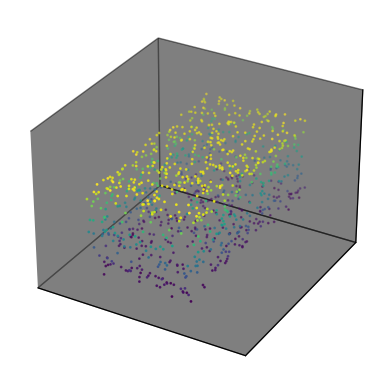

In [7]:
import random
import torch
from utils.plot import plot_points
from utils.display import show_collapsible_list

i = random.randint(0, len(cls_test_dataset) - 1)

input_data = cls_test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
exp = int(cls_test_dataset[i][1])
pre = scores.argmax().item()
show_collapsible_list("Scores", map(lambda x: str(x), scores.tolist()))
if exp == pre:
    print(
        f"\033[32m✓\033[0m Predicted class: \033[32m{cls_datasource_info.class_names[pre]} ({pre})\033[0m"
    )
else:
    print(
        f"\033[31m✗\033[0m Predicted class: \033[31m{cls_datasource_info.class_names[exp]} ({exp})\033[0m (Expected: {cls_datasource_info.class_names[pre]} ({pre}))"
    )

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Load data for the segmenter:


In [95]:
from utils.plot import plot_points
import random

from models.dataset import ElectricalPolesDataset

seg_dataset = ElectricalPolesDataset(npoints=128)
index = random.randint(0, len(seg_dataset))
plot_points(seg_dataset[index][0], seg_dataset[index][1])

print(max(seg_dataset[index][1]))

# for i in range(len(seg_dataset)):
#     try:
#         data = seg_dataset[i]
#         print(f"{i}: {data[0].shape} {data[1].shape}")
#     except Exception as e:
#         print(f"{i}: {e}")

IndexError: list index out of range

Train the segmenter:


In [2]:
from pointnet.segmentation import train_segmentation

train_segmentation(
    train_dataset=seg_dataset,
    test_dataset=seg_dataset,
    k=8,
    epochs=10,
    class_choice=1,
    outf="./pointnet/seg",
)

Random Seed:  9785


../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [23,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
